# Clustering Images without lables
Here in This project we implemented the KMeans clustering algorithm to cluster the images with their visual similarity.The project we tried to illustrate how we can use feature extracter to features from images then reduce the dimentionality and finally club them together in clusters without knowing the labels of images. 
Here is the detailed workflow of the whole project. 

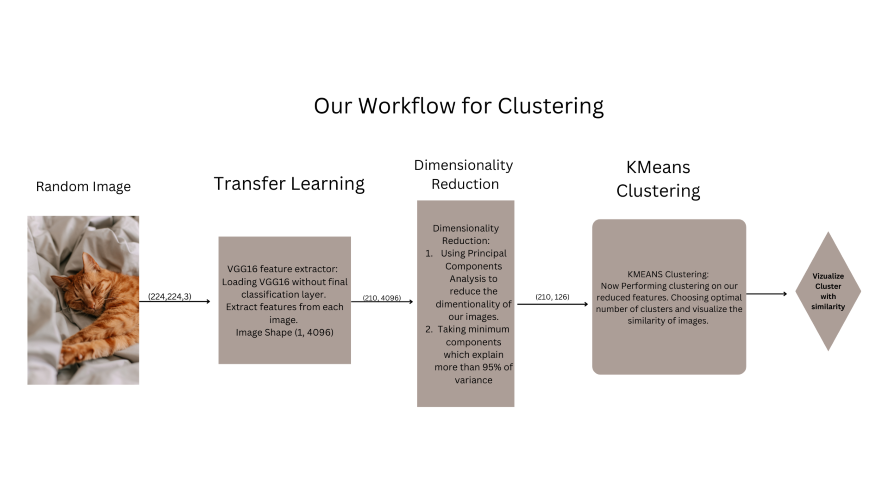

### Transfer learning for Feature extraction
Here we used the famous VGG16 pretrained model from keras repository to extract the features of images. This CNN model is pretrained on million of images from Imagenet dataset. We can use it as feature extractor by removing the final classification layer.

### Dimentionality reduction using PCA
As the features vector extracted from VGG16 has higher dimention around 4000. we tried to lower it's dimention for the computatoin purpose and reduced it by significant amout to preform the clustering

### Kmeans clustering
Here we wrote a kmeans class to perform kmeans clustering on our reduced features we got from apply PCA in previous steps
After that we used the Kmeans clustering for cluster our features vectors into k clusters. 

In [2]:
# necessary imports
import os  # For manipulating directories
import numpy as np  # to perform matrix operation
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from random import randint

from sklearn.decomposition import PCA  # Using PCA from SKlearn library
#from sklearn.cluster import KMeans  # Kmeans clustering algorithm from SKlearn
from sklearn.metrics import silhouette_score, silhouette_samples  # the performance metric for Clustering

from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input


from sklearn.preprocessing import StandardScaler  # Scaling with standard scaler
from skimage.io import imread_collection
from skimage.transform import resize

from matplotlib.cm import get_cmap

## The data
Our dataset is flowers dataset which can be downloaded from Kaggle on this [link](https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images). This is the dataset of 210 images with 10 differnt types of flowers. Each images is (128,128, 3) is shape. Meaning each images has height of 128, width of 128 and color channel RGB which is 3. All the images are in .png format and labels are in integers meaning form 0 to 10.

In [3]:
img_path = r"C:\Users\straw\Downloads\flower_images"  # setting up the path of images folder

os.chdir(img_path)  # changing working directory to the images folder to make things easier for us.

flower_names = []  # initializing a list to store the filenames of all the flowers

with os.scandir(img_path) as files:
    for file in files:
        if file.name.endswith(".png"):  # taking all the files with ending as (.png) and putting them in files.
            flower_names.append(file.name)
        

In [4]:
print(f"the number of images in the file are: {len(flower_names)}")

the number of images in the file are: 210


### Visualizing the Data

Here we will have a look at our images randomly to see what we're dealing with and how it looks before going further.

In [5]:
import random
def visualize_img(img_path):
    '''
    This function will take image folder path as input, reads the images and with disply the image.
    
    '''

    random_img = random.sample(flower_names, 1)  # taking random sample from the filenames list
    img = plt.imread(img_path + "/" + random_img[0])  # reading image from path
    plt.imshow(img)
    plt.axis("off")
    return img

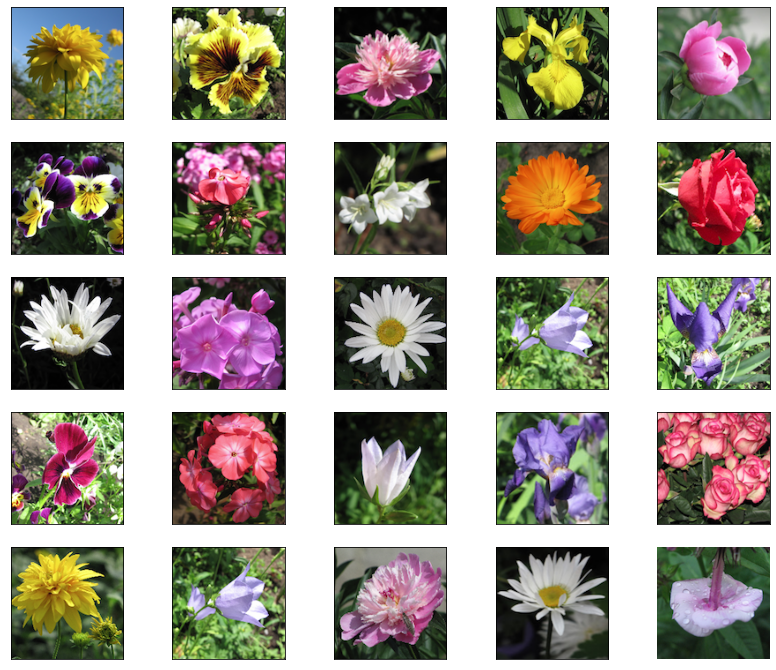

In [6]:
## visualizing 20 random images from our dataset

fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (14, 12),
                          subplot_kw = {'xticks': [], 'yticks': []})

for i , ax in enumerate(axes.flat):
  ax.imshow(visualize_img(img_path))

Up looking at our images as we can see we have different types of flowers with totally different visual features. Classifying them into their similarity will be a tedious task. But let's move on with it.

# VGG16 Model

Here we will load the pretrained VGG16 model and remove it's final layer which is classification layer this model was originally trained for classify 1000 types of objects. Here we can use the learning from this model to our leverage and use it as feature extractor for our task.

Here is the architecture of VGG16
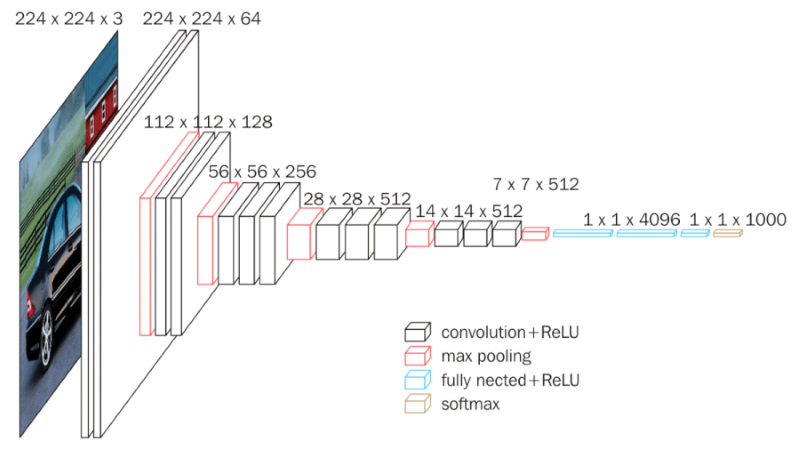

In [8]:
## loading the model
model = VGG16()  
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
# creating a new model that excludes the last classification layer.
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Preprocessing the Data
Now as the model is loaded it has some requirements for the input that needs to be provided for to the VGG16. so here we will be using keras *load_img* and *preprocess_img* methods to make the our images compatible for VGG16 to take as input. It requires data to be in shape of (224, 224) and model should know the number of images it is taking in so we will have to add an additional number of samples to the shape. So our final shape will look like **(Num_samples, img_height, img_width, color_channels)**

In [10]:
def feature_vec(file, model):
    ''' This function will take file(singe image) and model as and input and return the extracted
        features from the model.
    '''

    ## here first we have to load the image which needs to be (224,224) in shape.

    img = load_img(file, target_size = (224,224))

    img = np.array(img)  # converting from PIL image to numpy array

    reshapin_img = img.reshape(1,224,224,3)  # Reshaping it for model(Num_samples, height, width, color_channels)

    img_m = preprocess_input(reshapin_img)  # preparing image for model

    features = model.predict(img_m, use_multiprocessing=True)  # extracting features

    return features

In [11]:
## checking for a random sample
img_rand = load_img(flower_names[0], target_size = (224,224))
img_rand = np.array(img_rand)
img_rand.shape

(224, 224, 3)

In [13]:
img_rand = feature_vec(flower_names[0], model)

1/1 [==============================] - 1s 829ms/step


In [10]:
img_rand.shape

(1, 4096)

#### Now we will use this fucntion to extract features from the images and store them in dictionary to with filename as key and corresponding features as the value

In [14]:
feature_dict = {}  # initializing an empty dictionary

# iterating through every file
for flower in flower_names:  
    feat = feature_vec(flower, model)
    feature_dict[flower] = feat

# Now let's seriealise our data in bits format to able to use it later.
with open("feature_dict.pickle", "wb") as file:  
    pickle.dump(feature_dict, file)

1/1 [==============================] - 0s 219ms/step


In [15]:
filename = np.array(list(feature_dict.keys()))  # making of list of filenames in the dictionary

In [16]:
features = np.array(list(feature_dict.values())) # getting the corresponding list for features of images

In [17]:
features.shape  # checking the shape

(210, 1, 4096)

In [18]:
# reshaping the features array to get in the shape of (num_samples, num_vec)
features = features.reshape(-1, 4096)
features.shape

(210, 4096)

In [19]:
# looking at the 1 example of feature vector
print(f"The first image in vecotor form is : {features[0]}")
print(f"The maximum pixel value in first image is : {features[0].max()}")
print(f"The minimum pixel value in first image is : {features[0].min()}")

The first image in vecotor form is : [1.749906  0.        0.        ... 1.4705426 0.        0.       ]
The maximum pixel value in first image is : 10.386086463928223
The minimum pixel value in first image is : 0.0


Taking we will take the unique labels form the .csv file which contains the integers features of the images.


In [20]:
# loading the label file as pandas dataframe
label_df = pd.read_csv(r"C:\Users\straw\Downloads\flower_images\flower_labels.csv")

label = label_df['label'].tolist()
unique_label = list(set(label))  # extracting unique labels from the pandas dataframe

In [21]:
unique_label

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Dimentionality Reduction
So, now as we finished with extracting features for our images which as we remember a vector of 4096. Each element in that vector corresponds to specific feature or attribute to that image. It means we have a single image flattened to have around 4096 features. So we have total of 210 images with 4096 features each. Having 4096 features is quite a lot for computer to process and most of them might not contain the relevent information that is required to carry out our analysis. So here our motive is to save as much processing as we can and get the better results as possible. So there should be a balance between the amount of power and the results that we got.


# Principal Component Analysis
Here we will apply PCA to reduce the dimensions of our data to where we can see and work with as PCA will help us reduce the dimensions and give the importance principal compononents where the most variance is explained.

### What is PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional representation while preserving the most important information. It achieves this by finding a new set of orthogonal axes, called principal components, which capture the maximum amount of variation in the data.

Mathematically, PCA works by performing a linear transformation of the data to a new coordinate system. The first principal component corresponds to the direction of maximum variance in the data. The subsequent principal components are chosen in such a way that they capture the remaining variance while being orthogonal to the previous components.

### Standardize the data
If the features in the dataset have different scales, it is necessary to standardize the data by subtracting the mean and dividing by the standard deviation. This ensures that all features have the same scale and prevents features with larger variances from dominating the analysis.

### Compute the covariance matrix
The covariance matrix is calculated to determine the relationships between the features. It measures how much two variables vary together. The covariance between two features x and y is given by the formula:

$\text{{cov}}(x, y) = \frac{1}{{n-1}} \sum_{{i=1}}^n (x_i - \text{{mean}}(x))(y_i - \text{{mean}}(y))$


### Eigendecomposition
Eigendecomposition of the covariance matrix is carried out to obtain the eigenvectors and eigenvalues. The eigenvectors represent the principal components, and the eigenvalues indicate the amount of variance explained by each component. The eigenvectors are sorted in descending order based on their corresponding eigenvalues.

### Select the principal components
The desired number of principal components is chosen based on the explained variance. The explained variance represents the amount of variance in the data that is accounted for by each principal component. By selecting a subset of the principal components that capture a significant portion of the total variance, the dimensionality of the data can be reduced.

### Project onto selected PCs
The original data is transformed into the new lower-dimensional space by projecting it onto the selected principal components. This is done by taking the dot product of the data with the eigenvectors corresponding to the selected components.
The result of PCA is a reduced-dimensional representation of the original data, where the new dimensions (principal components) are uncorrelated and capture the maximum variance. By discarding the dimensions with lower variance, PCA effectively reduces the dimensionality of the data while preserving as much relevant information as possible.

### Standardizing the data

In [22]:
def mean(x): # np.mean(X, axis = 0)  
    return sum(x)/len(x)  

def std(x): # np.std(X, axis = 0)
    return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

def Standardize_data(X):
    return (X - mean(X))/std(X)

X_std = Standardize_data(features)

C:\Users\straw\AppData\Local\Temp/ipykernel_31892/802079475.py:8: RuntimeWarning: invalid value encountered in divide
  return (X - mean(X))/std(X)


### find the covariance matrix

In [23]:
def covariance(x): 
    return (x.T @ x)/(x.shape[0]-1)
cov_mat = covariance(features)

In [24]:
cov_mat.shape

(4096, 4096)

### find the eigenvectors and Eigenvalues

In [49]:
# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat) 

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs[:10])

Eigenvalues 
 [3742.514   590.7711  296.6785 ...    0.        0.        0.    ]
Eigenvectors 
 [[ 3.7166614e-03  1.2602010e-03  2.0929752e-03 ...  2.2275457e-02
   7.1514212e-03  1.4576700e-04]
 [-2.0144288e-03 -1.3488129e-03  1.9184622e-03 ...  2.0794945e-02
   1.3911730e-03 -1.1907927e-04]
 [-1.5913344e-03 -2.4816834e-03 -3.5156535e-03 ... -2.5474580e-02
  -8.8761719e-03 -2.5590871e-05]
 ...
 [ 1.2169251e-02  3.3542828e-03  6.4537342e-04 ... -2.0922609e-02
  -1.4322671e-03  6.5825600e-04]
 [-1.0708738e-02 -3.7324862e-03  6.3932948e-03 ...  2.8210875e-02
   2.7680730e-03 -1.0626144e-03]
 [-3.6319604e-03 -2.9611326e-04  2.6412734e-03 ... -2.0362234e-02
  -1.0483235e-02 -1.2706424e-04]]


### Rearraging eignenvalues and eigenvectors

In [92]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs[:5])

[(3742.514, array([0.00371666, 0.0012602 , 0.00209298, ..., 0.02227546, 0.00715142,
       0.00014577], dtype=float32)), (590.7711, array([-0.00201443, -0.00134881,  0.00191846, ...,  0.02079494,
        0.00139117, -0.00011908], dtype=float32)), (296.6785, array([-1.5913344e-03, -2.4816834e-03, -3.5156535e-03, ...,
       -2.5474580e-02, -8.8761719e-03, -2.5590871e-05], dtype=float32)), (223.77916, array([-0.01128454,  0.00137495,  0.00244059, ..., -0.00609009,
       -0.00110489,  0.00052272], dtype=float32)), (197.79095, array([-0.01205095,  0.0012918 , -0.00030041, ...,  0.05185313,
        0.02342238, -0.00077182], dtype=float32)), (158.74677, array([-0.00876845,  0.00047247,  0.00779285, ..., -0.04026106,
        0.00365524,  0.00032777], dtype=float32)), (143.73067, array([-0.0065644 ,  0.00249811, -0.00602843, ...,  0.04195908,
       -0.0176925 ,  0.00107892], dtype=float32)), (113.36753, array([ 0.01216925,  0.00335428,  0.00064537, ..., -0.02092261,
       -0.00143227,  0.00

### Choosing Principal components


In [93]:
# selecting the number of componenets
k = 150
W = eig_vecs_sorted[:k, :]  # projection matrix
print(W.shape)

(150, 4096)


#### Not value of k can be set in a way through the explained variance. Explained variance tells us how much information can be attributed to each of principal components.


In [94]:
eigvals_total = sum(eig_vals)
explained_variance = [(i / eigvals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

Explained variance: [48.57  7.67  3.85 ...  0.    0.    0.  ]
Cumulative explained variance: [ 48.57  56.24  60.09 ... 100.   100.   100.  ]


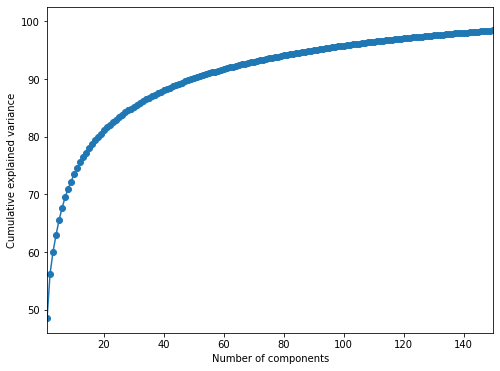

In [95]:

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), cum_explained_variance, '-o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xlim(1, 150)  # Set the x-axis limits from 1 to 150
#plt.xticks(np.arange(1, len(explained_variance) + 1, 10))  # Adjust the x-axis tick positions as desired
plt.show()


#### Project the data

In [75]:
X_reduced = X_std.dot(W.T)

print(X_reduced.shape)

(210, 150)


### PCA with Sklearn

In [25]:
pca = PCA()
pca.fit(features)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.95) + 1

In [26]:
num_components

126

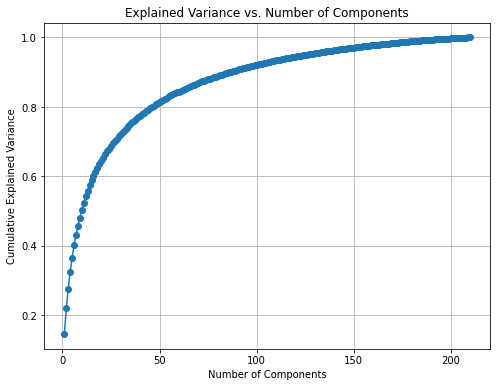

In [99]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [27]:
## here we will get our features in reduced space
reduced_features = pca.transform(features)[:, :num_components]

In [23]:
reduced_features.shape

(210, 126)

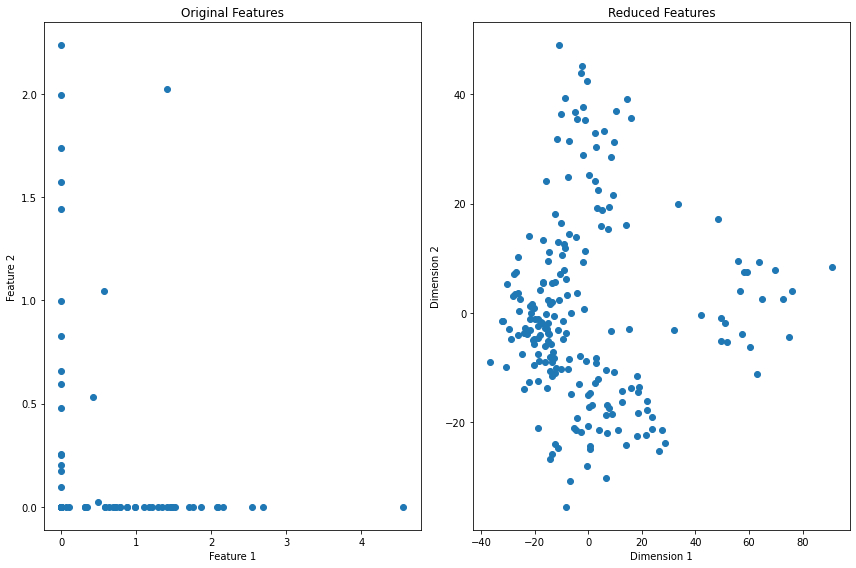

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
# Scatter plot of original features
plt.subplot(1, 2, 1)  # Create a subplot with 1 row and 2 columns, plot the original features in the first column
plt.scatter(features[:, 0], features[:, 1])
plt.title('Original Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Scatter plot of reduced features
plt.subplot(1, 2, 2)  # Plot the reduced features in the second column
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title('Reduced Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()  # Adjust the layout to avoid overlapping plots
plt.show()

Here our Number of features has been reduced to 126. These 126 features explain the most of our variance and are most important fetures that captures the complexity of our images. So This is the magic of PCA it reduced our features from 4096 to 126. which is more than 95 percent decrease. Principal component analysis is one of the most widely used statistics techinique to reduced the dimentionaly of data.

## Similarity in clusters
Most common way to compare similarity of two data points is using distance .
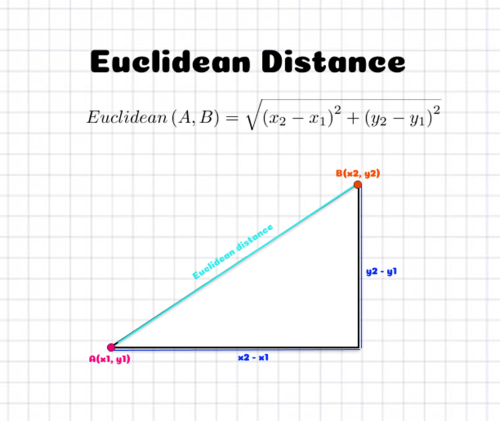


## KMeans Clustering
**What is KMeans Clustering**\
K-means clustering is a popular unsupervised machine learning algorithm used to partition a dataset into a specified number of clusters. The goal of K-means clustering is to group similar data points together while maximizing the separation between different clusters.
1. **Initialization**
- Choose the number of clusters, K, that you want to identify in the data.
- Initialize K cluster centroids randomly or using some predefined criteria.

2. **Assignment**
- For each data point, calculate the Euclidean distance or any other distance metric from the data point to each of the K centroids.
- Assign the data point to the cluster with the closest centroid.

3. **Update**
- Recalculate the centroid of each cluster by taking the mean of all the data points assigned to that cluster.
- Update the position of each centroid to the new mean value.

4. **Iteration**
- Repeat steps 2 and 3 until convergence or a predefined number of iterations.
- Convergence occurs when the centroids no longer move significantly or when a maximum number of iterations is reached.


The final output of the K-means algorithm is a set of K cluster centroids and the assignment of each data point to a specific cluster.

Mathematically Kmeans can be expressed as:
$$ J = \sum_{i=1}^{N} \min_{j=1}^{K} \| x_i - c_j \|^2 $$

where:
- J is the objective function
- $x_i$ represents a data point
- $c_j$ represents a cluster centroid
- K is the number of clusters
- ||.|| represents the Euclidean distance between two points

The algorithm iteratively updates the cluster centroids and reassigns the data points to clusters to minimize the objective function J.

K-means clustering aims to find a locally optimal solution, and the results can vary depending on the initialization of the centroids. Multiple runs of the algorithm with different initializations can help identify a better overall solution.

It's important to note that K-means clustering assumes that the clusters are spherical, equally sized, and have similar densities. It may not perform well on datasets with complex structures or unevenly sized clusters.

In [29]:
np.random.seed(1)


class KMeans(object):

    def __init__(self):  
        pass

    def pairwise_dist(self, x, y): 
        """
        Calculate the pariwise distance between 2 arrays.
        Args:
            x: N x D numpy array
            y: M x D numpy array
        Return:
                dist: N x M array, where dist2[i, j] is the euclidean distance between 
                x[i, :] and y[j, :]
        """
        x_sum_square = np.sum(np.square(x),axis=1);
        y_sum_square = np.sum(np.square(y),axis=1);
        mul = np.dot(x, y.T);
        dists = np.sqrt(abs(x_sum_square[:, np.newaxis] + y_sum_square-2*mul))
        return dists

    def initialize_centers(self, points, K):
        """
        Initialize the cluster centers
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            kwargs: any additional arguments you want
        Return:
            centers: K x D numpy array, the centers. 
        """
        row, col = points.shape
        centers = np.empty([K, col])
        for number in range(K):
            rand_index = np.random.randint(row)
            centers[number] = points[rand_index]
        
        return centers

    def update_assignment(self, centers, points): 
        """
        Update the cluster assignment for each point.
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            points: NxD numpy array, the observations
        Return:
            cluster_idx: numpy array of length N, the cluster assignment for each point
.
        """
        row, col = points.shape
        cluster_idx = np.empty([row])
        distances = self.pairwise_dist(points, centers)
        cluster_idx = np.argmin(distances, axis=1)

        return cluster_idx

    def update_centers(self, old_centers, cluster_idx, points):  # [10 pts]
        """
        Update the cluster centers.
        Args:
            old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
        """
        K, D = old_centers.shape
        new_centers = np.empty(old_centers.shape)
        for i in range(K):
            new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
        return new_centers

    def get_loss(self, centers, cluster_idx, points):  
        """
        Calculate the loss the objective function of KMeans
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        """
        dists = self.pairwise_dist(points, centers)
        loss = 0.0
        N, D = points.shape
        for i in range(N):
            loss = loss + np.square(dists[i][cluster_idx[i]])
        
        return loss

    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, verbose=False):
        """
        perform kmeans clustering on the given points
        
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            verbose: boolean to set whether method should print loss
            kwargs: any additional aruguments we want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: K x D numpy array, the centers
            loss: final loss value of the objective function of KMeans
        """
        centers = self.initialize_centers(points, K)
        for it in range(max_iters):
            cluster_idx = self.update_assignment(centers, points)
            centers = self.update_centers(centers, cluster_idx, points)
            loss = self.get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            if verbose:
                print('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers, loss
    
    def find_optimal_num_clusters(self, data, max_K=15):
        """
        Plots loss values for different number of clusters in K-Means

        Args:
            image: input image of shape(H, W, 3)
            max_K: number of clusters
        Return:
            None (plot loss values against number of clusters)
        """
        y_val = np.empty(max_K)

        for i in range(max_K):
            cluster_idx, centers, y_val[i] = KMeans()(data, i + 1)
            
        plt.plot(np.arange(max_K) + 1, y_val)
        plt.show()
        return y_val

In [30]:
kmeans = KMeans()  # initializing the kmeans object

In [31]:
points = reduced_features  # making the input for our object

In [32]:
cluster_idx, centers, loss = kmeans(points, K=10, max_iters = 100, abs_tol=1e-16, rel_tol=1e-16, verbose=False)

In the scatter plot, each point represents a data sample, and the color represents its assigned cluster. The plot allows you to visualize the separation or grouping of data points based on the assigned clusters. If there is clear separation between different colored clusters, it suggests that the K-means algorithm has successfully grouped similar data points together. On the other hand, if the clusters overlap or there is no distinct separation, it may indicate that the K-means algorithm is not able to effectively cluster the data.
 it suggests that there is some degree of ambiguity or overlap between those clusters. This can indicate that the data points belonging to these clusters have similar feature values, making it challenging for the clustering algorithm to distinguish them completely.

Possible interpretations for overlapping clusters could include:

Similar Data: The data points in the overlapping clusters may represent similar patterns or instances within the dataset. It could indicate that these instances share common characteristics or exhibit similar behavior.

Feature Redundancy: The features used for clustering may contain redundant or highly correlated information, leading to overlapping clusters. In such cases, reducing feature dimensionality or performing feature selection may help improve cluster separation.

Complex Relationships: The underlying data distribution may have complex relationships or overlapping patterns that cannot be easily captured by the clustering algorithm. In such cases, alternative clustering methods or incorporating additional domain knowledge could be explored.

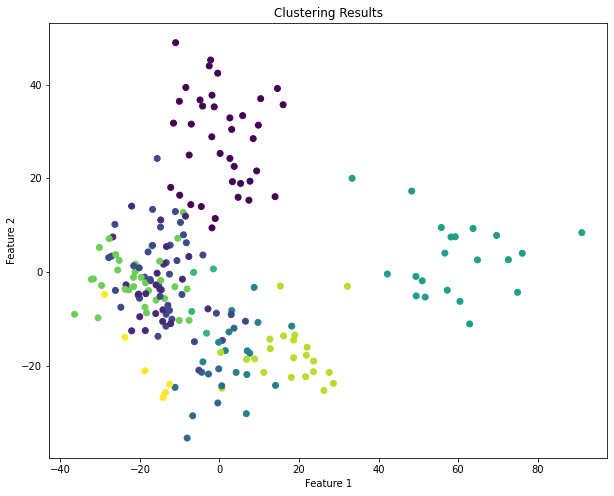

In [45]:
# Create a scatter plot of the clusters
plt.figure(figsize=(10,8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_idx, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

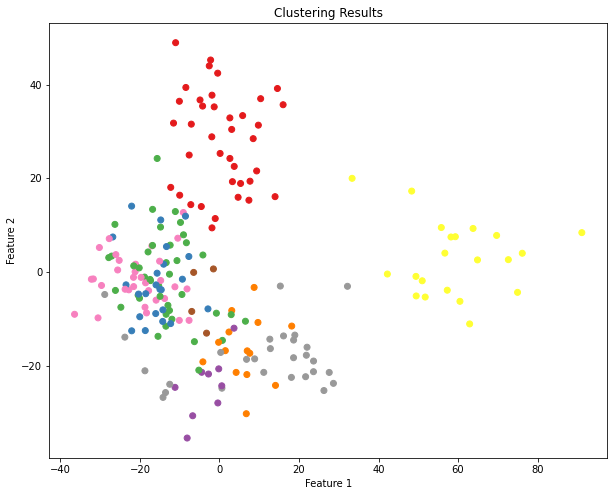

In [46]:
# Create a scatter plot of the clusters
plt.figure(figsize=(10,8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_idx, cmap='Set1')
plt.title('Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Cluster centriods Analysis
Visualizing the clusters centers and data points in scatter plots.

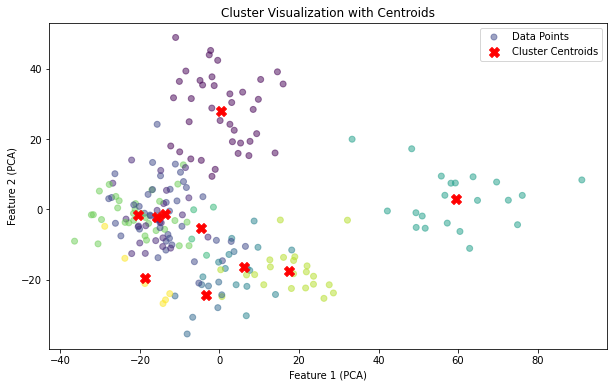

In [44]:
# Plot the data points and cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_idx, cmap='viridis', alpha=0.5, label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Cluster Centroids')
plt.title('Cluster Visualization with Centroids')
plt.xlabel('Feature 1 (PCA)')
plt.ylabel('Feature 2 (PCA)')
plt.legend()
plt.show()


### Features contribution analysis
By examining the heatmap, you can identify which features are more important for each cluster and how they contribute to the clustering process.

In [40]:
num_top_features = 10  # Choose the number of top features to visualize for each cluster
# Calculate feature importance (variance) for each feature based on the cluster centers
feature_importance = np.var(centers, axis=0)
# Sort features based on their importance (descending order)
sorted_features_idx = np.argsort(feature_importance)[::-1]
sorted_features_importance = feature_importance[sorted_features_idx]


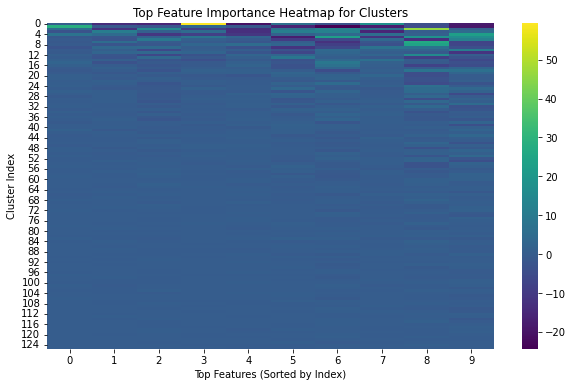

In [41]:
top_features_idx = sorted_features_idx[:num_top_features] 
# Transpose the cluster_centers matrix for heatmap visualization
cluster_centers_transposed = np.transpose(centers)

plt.figure(figsize=(10, 6))

sns.heatmap(cluster_centers_transposed[:, top_features_idx], cmap='viridis')
plt.xlabel('Top Features (Sorted by Index)')
plt.ylabel('Cluster Index')
plt.title('Top Feature Importance Heatmap for Clusters')
plt.show()

In [47]:
labels = cluster_idx  # The cluster assignments from KMeans

# Print the labels of the clusters
for i in range(10):
    cluster_images = np.where(labels == i)[0]
    print(f"Cluster {i}: {cluster_images}")

Cluster 0: [  6  10  18  19  24  27  32  33  36  56  58  64  65  70  74  77  85  92
  95  97 103 107 110 114 118 120 123 130 143 153 157 160 169 175 181 193
 197 202]
Cluster 1: [ 50  91  99 104 124 140 148 149 154 156 158 161 162 165 167 168 170 171
 172 173 188 200 209]
Cluster 2: [  0   1   3   4   9  11  12  16  17  30  37  40  43  47  53  54  57  63
  67  72  75  83  96 109 113 115 119 125 127 136 142 146 155 159 180 184
 185 201 203 206 208]
Cluster 3: [ 25  31  55 117 129 137 183 196 198]
Cluster 4: [ 13  14  22  42  46  52  62  71  90 145 152 166 179 191]
Cluster 5: [ 21  45  51  69  81  87  89 102 111 122 133 134 139 141 147 151 177 190
 199 204 207]
Cluster 6: [ 34  79  82 195]
Cluster 7: [  5   7   8  15  35  39  41  44  48  49  59  61  73  78  80  84  94  98
 100 106 108 116 128 132 135 164 174 176 182 187 192 194]
Cluster 8: [  2  20  23  26  28  38  60  68  86  93 101 105 112 121 126 131 138 144
 150 163 178 189]
Cluster 9: [ 29  66  76  88 186 205]


In [29]:
cluster_dict = {}

for i in range(10):
    cluster_images = np.where(labels == i)[0]
    cluster_dict[i] = cluster_images

In [30]:
cluster_filenames = {}  ## dict to store cluster with their image filename
for cluster, image_indices in cluster_dict.items():
    filenames = [filename[index] for index in image_indices]
    cluster_filenames[cluster] = filenames


In [31]:
cluster_filenames

{0: ['0007.png',
  '0011.png',
  '0019.png',
  '0020.png',
  '0025.png',
  '0028.png',
  '0033.png',
  '0034.png',
  '0037.png',
  '0057.png',
  '0059.png',
  '0065.png',
  '0066.png',
  '0071.png',
  '0075.png',
  '0078.png',
  '0086.png',
  '0093.png',
  '0096.png',
  '0098.png',
  '0104.png',
  '0108.png',
  '0111.png',
  '0115.png',
  '0119.png',
  '0121.png',
  '0124.png',
  '0131.png',
  '0144.png',
  '0154.png',
  '0158.png',
  '0161.png',
  '0170.png',
  '0176.png',
  '0182.png',
  '0194.png',
  '0198.png',
  '0203.png'],
 1: ['0051.png',
  '0092.png',
  '0100.png',
  '0105.png',
  '0125.png',
  '0141.png',
  '0149.png',
  '0150.png',
  '0155.png',
  '0157.png',
  '0159.png',
  '0162.png',
  '0163.png',
  '0166.png',
  '0168.png',
  '0169.png',
  '0171.png',
  '0172.png',
  '0173.png',
  '0174.png',
  '0189.png',
  '0201.png',
  '0210.png'],
 2: ['0001.png',
  '0002.png',
  '0004.png',
  '0005.png',
  '0010.png',
  '0012.png',
  '0013.png',
  '0017.png',
  '0018.png',
  '0031.p

In [32]:
def view_cluster(cluster):
    '''
    This function takes a cluster which is integer value from 0-9, and outputs the images of corresponding cluster
    with the cluster value as the header also the visualization of cluster is limited to 25 at a time.
    
    '''
    plt.figure(figsize=(20,20))
    files = cluster_filenames[cluster]  # getting the list of filenames for cluster

    if len(files) > 25:   # only allowing upto 35 images per clusters
        print(f"cliping cluster size from {len(files)} to 25")
        files = files[:34]

    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cluster)

## Visualizing the clustering results
For more analysis here we visualize the results of clustering

cliping cluster size from 38 to 25


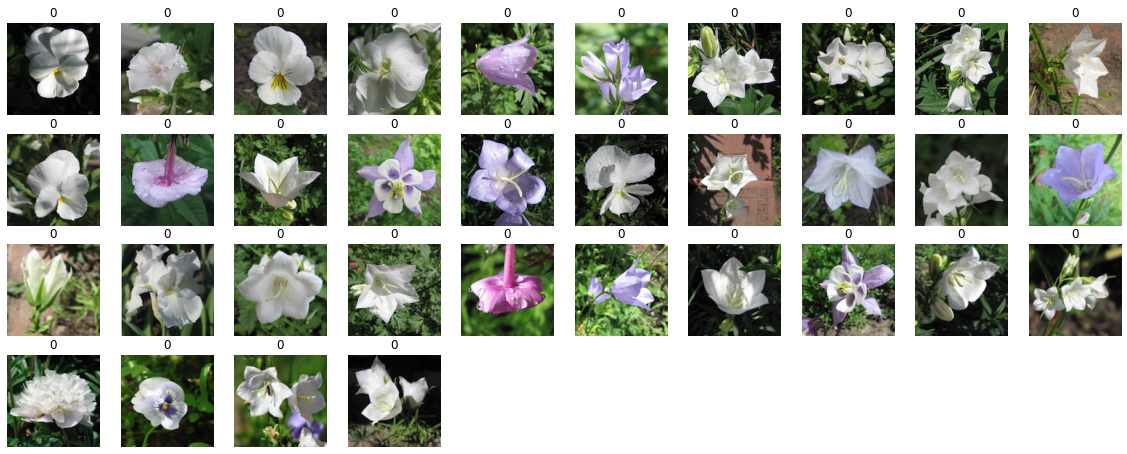

In [33]:
view_cluster(0)

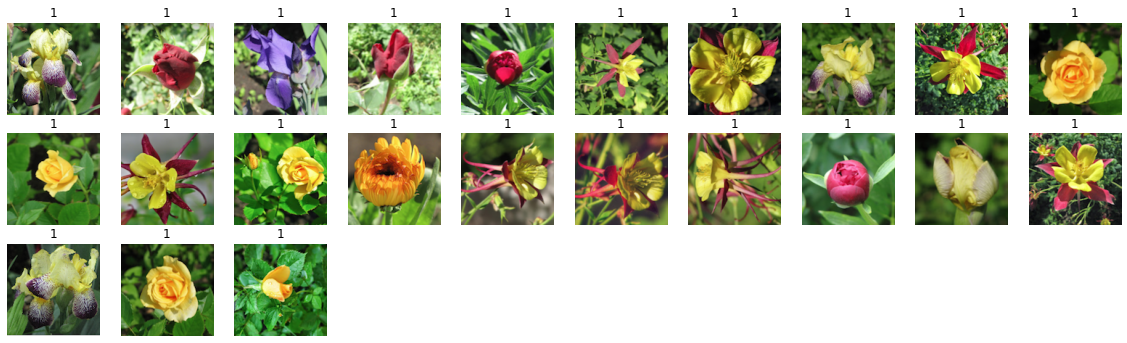

In [34]:
view_cluster(1)

cliping cluster size from 41 to 25


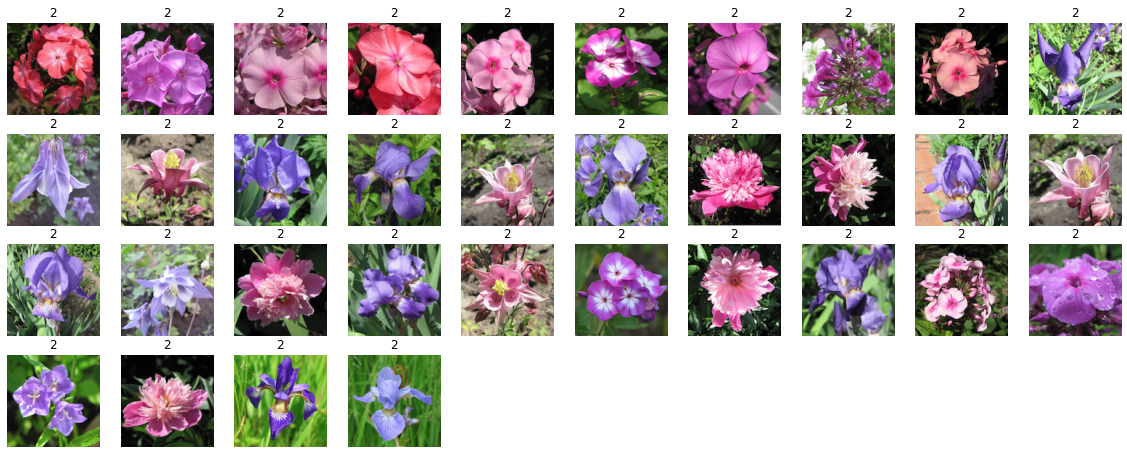

In [35]:
view_cluster(2)

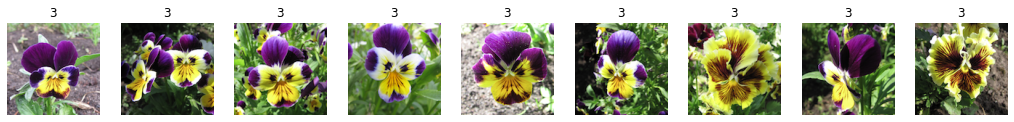

In [36]:
view_cluster(3)

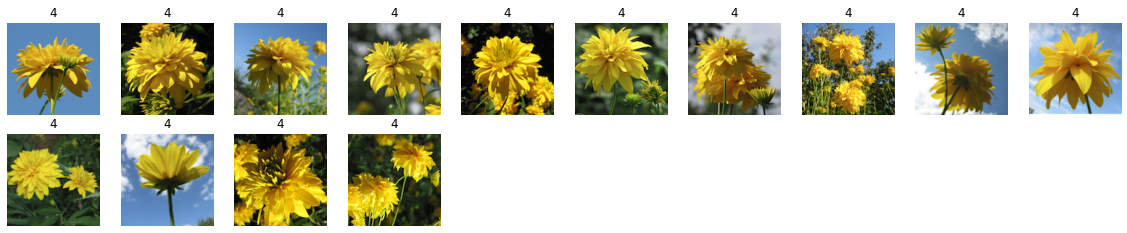

In [37]:
view_cluster(4)

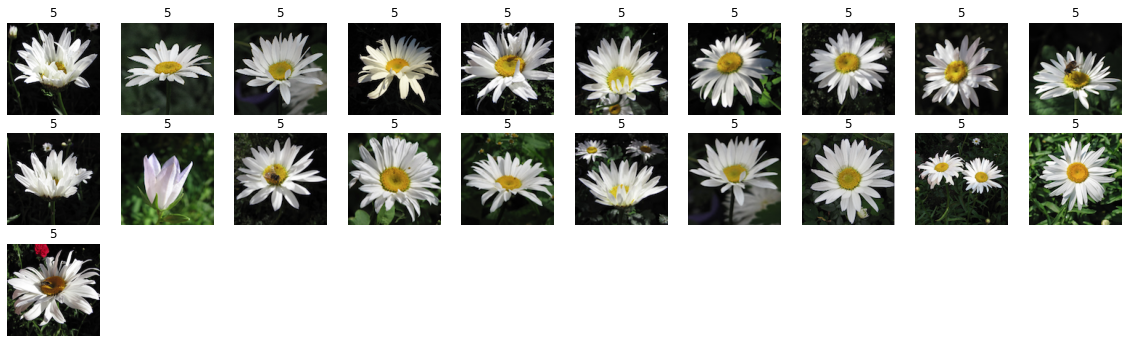

In [38]:
view_cluster(5)

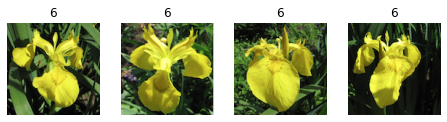

In [67]:
view_cluster(6)

cliping cluster size from 32 to 25


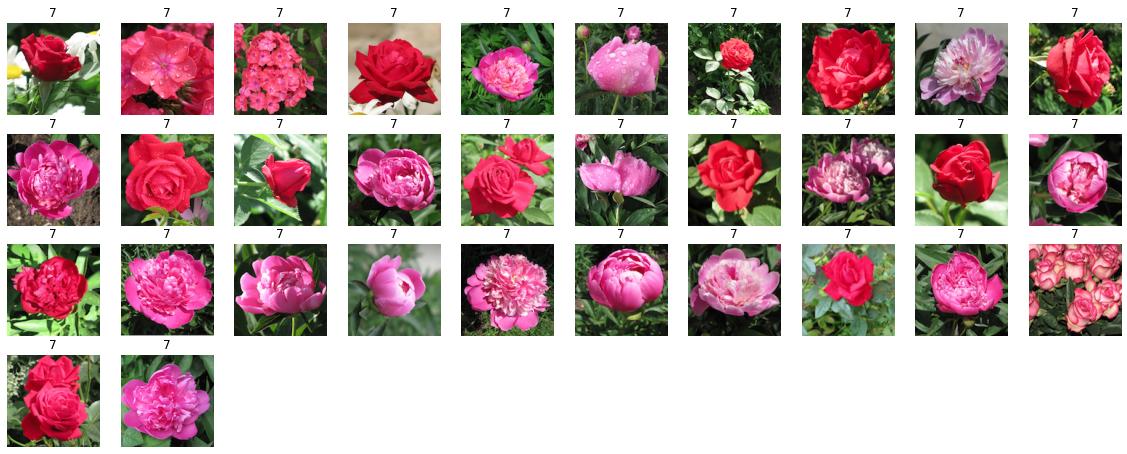

In [68]:
view_cluster(7)

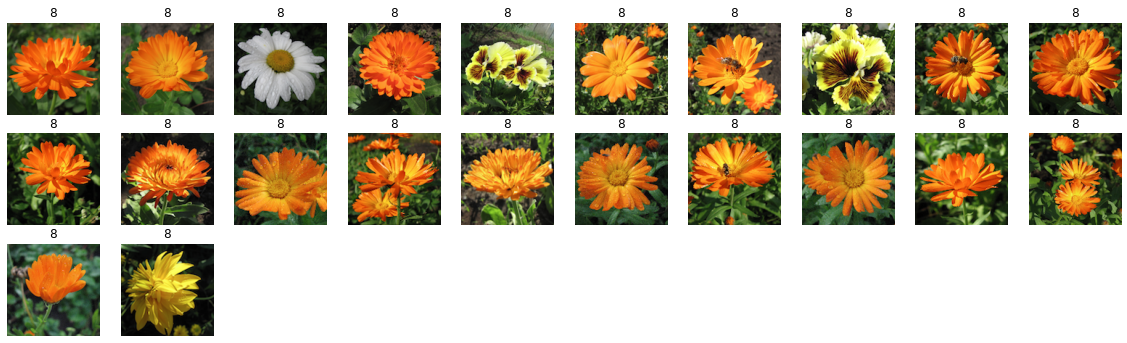

In [69]:
view_cluster(8)

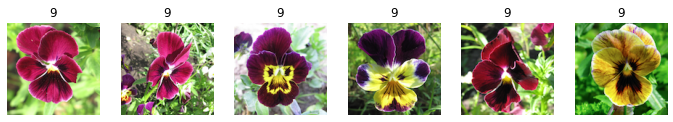

In [70]:
view_cluster(9)

### Elbow Method
Here we will use the Elbow method to determine the optimal number of clusters for that we have to perform Kmeans several times and increase number of cluster each time and record the loss for all times and plot the line graph.

So in order to chose the correct number of clusters we have to perform visual inspection and and see where loss curve starts to bend. That point is called **Elbow Point**. Elbow point represents a reasonable tradeoff between error and number of clusters. So in our case the elbow point seems to be 10 which is good as our number of classes are also 10.

C:\Users\straw\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\straw\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


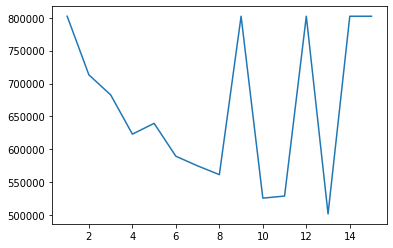

In [41]:
data = reduced_features  # Your input data of shape (N, D)
max_K = 15  # Maximum number of clusters to consider
y_val = kmeans.find_optimal_num_clusters(data, max_K)

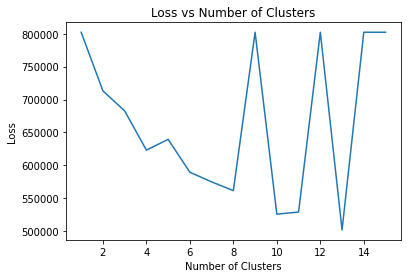

In [42]:
plt.plot(np.arange(max_K) + 1, y_val)
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Loss vs Number of Clusters')
plt.show()

In [44]:
import numpy as np
from sklearn.metrics import silhouette_score

# Assuming you have the cluster assignments in cluster_idx and the reduced feature matrix in reduced_features

silhouette_avg = silhouette_score(points, cluster_idx)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.10198588


## Silhouette analysis
We also performed the silhoutte analysis for our data and checked what will be the toptimal number of clusters which would have gotten us to a better silhouette score.
After applying we found out that we our score never goes above 0.1 and we get the better score around number of clusters equal to 10 which seems optimal

In [45]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt


In [48]:
silhouette_scores = []
min_k = 6
max_k = 20
for k in range(min_k, max_k+1):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(reduced_features)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

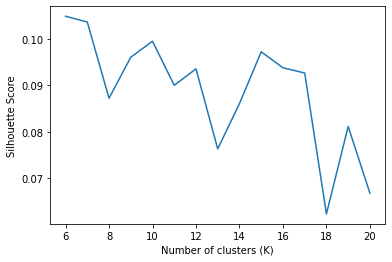

In [49]:
plt.plot(range(min_k, max_k+1), silhouette_scores)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [73]:
from sklearn import metrics

# Calculate Silhouette Coefficient
# silhouette_score = metrics.silhouette_score(features, labels)

# Calculate Inertia
# inertia = kmeans.inertia_

# # Calculate Adjusted Rand Index
ari = metrics.adjusted_rand_score(label, cluster_idx)

# # Calculate Normalized Mutual Information
nmi = metrics.normalized_mutual_info_score(label, cluster_idx)

In [74]:
print("Silhouette Coefficient:", silhouette_score)
# print("Inertia:", inertia)
print("Adjusted Rand Index:", ari) 
print("Normalized Mutual Information:", nmi)

Silhouette Coefficient: <function silhouette_score at 0x0000020221657BE0>
Adjusted Rand Index: 0.41851115307905945
Normalized Mutual Information: 0.6272050209762562


**Here we also use ARI and NMI as additional metrics to see how good is our clustering for images** 
Adjusted Rand Index (ARI): ARI measures the similarity between two clusterings, taking into account all pairs of samples and considering both the true and predicted cluster assignments. The ARI score ranges from -1 to 1, where 1 indicates perfect similarity between the two clusterings, 0 indicates random similarity, and negative values indicate dissimilarity.

In your case, the ARI score of 0.4185 suggests a moderate agreement between the true and predicted cluster assignments. It indicates that there is some degree of similarity between the two, but it is not a perfect match.

Normalized Mutual Information (NMI): NMI measures the mutual information between two clusterings, normalized by the average entropy of the two clusterings. It ranges from 0 to 1, where 1 indicates perfect agreement between the two clusterings and 0 indicates no mutual information.

The NMI score of 0.6272 suggests a relatively high level of agreement between the true and predicted cluster assignments. It indicates that there is a substantial amount of shared information between the two clusterings.